In [5]:
import numpy as np
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like # may be necessary in some versions of pandas
import pandas_datareader.data as web

In [6]:
def get_symbols(symbols, data_source, begin_date=None, end_date=None):
    out = pd.DataFrame()
    for symbol in symbols:
        df = web.DataReader(symbol, data_source, begin_date, end_date, api_key='2gwP5WpwYPiHshKy1H9v')\
        [['AdjOpen','AdjHigh','AdjLow','AdjClose','AdjVolume']].reset_index()
        df.columns = ['date','open','high','low','close','volume'] #my convention: always lowercase
        df['symbol'] = symbol # add a new column which contains the symbol so we can keep multiple symbols in the same dataframe
        df = df.set_index(['date', 'symbol'])
        out = pd.concat([out, df], axis=0) #stacks on top of previously collected data
    return out.sort_index()
        
prices = get_symbols(['AAPL','CSCO'], data_source='quandl', begin_date='2015-01-01',end_date='2017-01-01')

In [7]:
print(prices.index)
features = pd.DataFrame(index=prices.index).sort_index()
features['f01'] = prices.close/prices.open-1 # daily return
features['f02'] = prices.open/prices.groupby(level='symbol').close.shift(1)-1 
print(features.tail())

MultiIndex([('2015-01-02', 'AAPL'),
            ('2015-01-02', 'CSCO'),
            ('2015-01-05', 'AAPL'),
            ('2015-01-05', 'CSCO'),
            ('2015-01-06', 'AAPL'),
            ('2015-01-06', 'CSCO'),
            ('2015-01-07', 'AAPL'),
            ('2015-01-07', 'CSCO'),
            ('2015-01-08', 'AAPL'),
            ('2015-01-08', 'CSCO'),
            ...
            ('2016-12-23', 'AAPL'),
            ('2016-12-23', 'CSCO'),
            ('2016-12-27', 'AAPL'),
            ('2016-12-27', 'CSCO'),
            ('2016-12-28', 'AAPL'),
            ('2016-12-28', 'CSCO'),
            ('2016-12-29', 'AAPL'),
            ('2016-12-29', 'CSCO'),
            ('2016-12-30', 'AAPL'),
            ('2016-12-30', 'CSCO')],
           names=['date', 'symbol'], length=1008)
                        f01       f02
date       symbol                    
2016-12-28 CSCO   -0.009121  0.000652
2016-12-29 AAPL    0.002404 -0.002655
           CSCO    0.002963 -0.001644
2016-12-30 AAPL   -0.00

In [9]:
features['f03'] = prices.volume.apply(np.log) # log of daily volume
features['f04'] = prices.groupby(level='symbol').volume.diff(50) # change since 50 days prior

In [10]:
pct_chg_fxn = lambda x: x.pct_change()
features['f05'] = prices.groupby(level='symbol').volume.apply(pct_chg_fxn) 

In [14]:
# log of 5 day moving average of volume
ma_5 = lambda x: x.rolling(5).mean()
features['f06'] = prices.volume.groupby(level='symbol').apply(ma_5)\
.apply(np.log) 

print(features['f06'].head(5))

# daily volume vs. 200 day moving average
ma_200 = lambda x: x.rolling(200).mean()
features['f07'] = prices.volume / prices.volume.groupby(level='symbol')\
.apply(ma_200)-1

# daily closing price vs. 50 day exponential moving avg
ema_50 = lambda x: x.ewm(span=50).mean()
features['f08'] = prices.close / prices.close.groupby(level='symbol')\
.apply(ema_50)-1

date        symbol
2015-01-02  AAPL     NaN
            CSCO     NaN
2015-01-05  AAPL     NaN
            CSCO     NaN
2015-01-06  AAPL     NaN
Name: f06, dtype: float64


symbol          AAPL      CSCO
date                          
2015-01-02 -0.487364 -0.682407
2015-01-05 -0.783944 -0.925487
2015-01-06 -0.782981 -0.929906
2015-01-07 -0.639506 -0.819415
2015-01-08 -0.240856 -0.726603
...              ...       ...
2015-05-20  1.610044  0.305817
2015-05-21  1.739148  0.221203
2015-05-22  1.850779  0.145496
2015-05-26  1.567332  0.007442
2015-05-27  1.802729  0.167763

[100 rows x 2 columns]


<AxesSubplot:title={'center':'Z-Scores (not quite accurate)'}, ylabel='Density'>

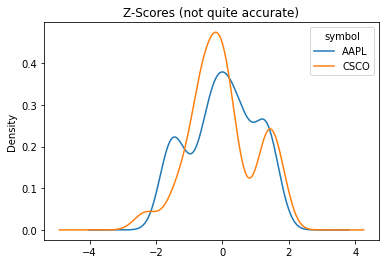

In [19]:
zscore_fxn = lambda x: (x - x.mean()) / x.std()
features['f09'] =prices.groupby(level='symbol').close.apply(zscore_fxn)
features.f09.unstack().plot.kde(title='Z-Scores (not quite accurate)')

In [ ]:
zscore_fun_improved = lambda x: (x - x.rolling(window=200, min_periods=20).mean())\
/ x.rolling(window=200, min_periods=20).std()
features['f10'] =prices.groupby(level='symbol').close.apply(zscore_fun_improved)
features.f10.unstack().plot.kde(title='Z-Scores (accurate)')

In [24]:
rollrank_fxn = lambda x: x.rolling(200,min_periods=20)\
.apply(lambda x: pd.Series(x).rank(pct=True)[0])
features['f11'] = prices.groupby(level='symbol').volume.apply(rollrank_fxn)

In [27]:
features['f12'] = features['f07'].dropna().groupby(level='date').rank(pct=True) 

date        symbol
2015-10-16  AAPL     -0.276595
            CSCO     -0.271157
2015-10-19  AAPL     -0.450086
            CSCO     -0.240542
2015-10-20  AAPL     -0.093851
Name: f07, dtype: float64


In [42]:
import ta

#Money Flow Index under 20 oversold, over 80 overbought
features['f13'] = ta.volume.money_flow_index(prices.high, \
                                         prices.low, prices.close, \
                                         prices.volume, 14, fillna=False)

In [43]:
# mean-centered money flow index

features['f14'] = features['f13'] - features['f13']\
.rolling(200, min_periods=20).mean()

In [44]:
# binning

n_bins = 10
bin_fxn = lambda y: pd.qcut(y, q=n_bins, labels = range(1,n_bins+1))
features['f15'] = prices.volume.groupby(level='symbol').apply(bin_fxn)

In [45]:
#signing

features['f16'] = features['f05'].apply(np.sign)

In [46]:
#plus-minus

plus_minus_fxn = lambda x: x.rolling(20).sum()
features['f17'] = features['f16'].groupby(level='symbol').apply(plus_minus_fxn)

In [47]:
month_of_year = prices.index.get_level_values(level='date').month
one_hot_frame = pd.DataFrame(pd.get_dummies(month_of_year))
one_hot_frame.index = prices.index # Careful! This is forcing index values without usual pandas alignments!

# create column names 
begin_num = int(features.columns[-1][-2:]) + 1 #first available feature
feat_names = ['f'+str(num) for num in list(range(begin_num,begin_num+12,1))]

# rename columns and merge
one_hot_frame.columns = feat_names
features = features.join(one_hot_frame)
print(features.iloc[:,-12:].tail())

                   f18  f19  f20  f21  f22  f23  f24  f25  f26  f27  f28  f29
date       symbol                                                            
2016-12-28 CSCO      0    0    0    0    0    0    0    0    0    0    0    1
2016-12-29 AAPL      0    0    0    0    0    0    0    0    0    0    0    1
           CSCO      0    0    0    0    0    0    0    0    0    0    0    1
2016-12-30 AAPL      0    0    0    0    0    0    0    0    0    0    0    1
           CSCO      0    0    0    0    0    0    0    0    0    0    0    1
